PARTIE 1

Imports

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import OneHotEncoder, StandardScaler #encodage et standardisation
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split

train = pd.read_csv("train_nettoye.csv")
test = pd.read_csv("test_nettoye.csv")

In [ ]:
test.shape

(1459, 80)

In [ ]:
#Séparation variable cible et variales explicatives
X_train = train.drop(columns=["SalePrice", "SalePrice_log", "Id"])
y_train = train["SalePrice_log"]

X_test = test.drop(columns=["Id"])


Separation des variables quantitatives et qualitatives

In [ ]:
variables_qualitatives = X_train.select_dtypes(include="object").columns
variables_quantitatives = X_train.select_dtypes(exclude="object").columns

len(variables_qualitatives), len(variables_quantitatives)


(43, 36)

- Encodage des variables qualitatives avec le one hot encoding
- Et standardisation des variables quantitatives


In [ ]:
#code issu de https://scikit-learn.org/stable/modules/preprocessing.html et chatgpt
preparation_donnees = ColumnTransformer(
    transformers=[
        ("variables_quantitatives", StandardScaler(), variables_quantitatives),
        ("variables_qualitatives", OneHotEncoder(handle_unknown="ignore"), variables_qualitatives)
    ]
)

In [ ]:
X_train_prepare = preparation_donnees.fit_transform(X_train) #on applique le prétraitement aux données d’entraînement
X_test_prepare = preparation_donnees.transform(X_test) #on applique les mêmes transformations au jeu de test


In [ ]:
train.to_csv("train_pret.csv", index=False)
test.to_csv("test_pret.csv", index=False)

PARTIE 2

Heatmap des corrélations

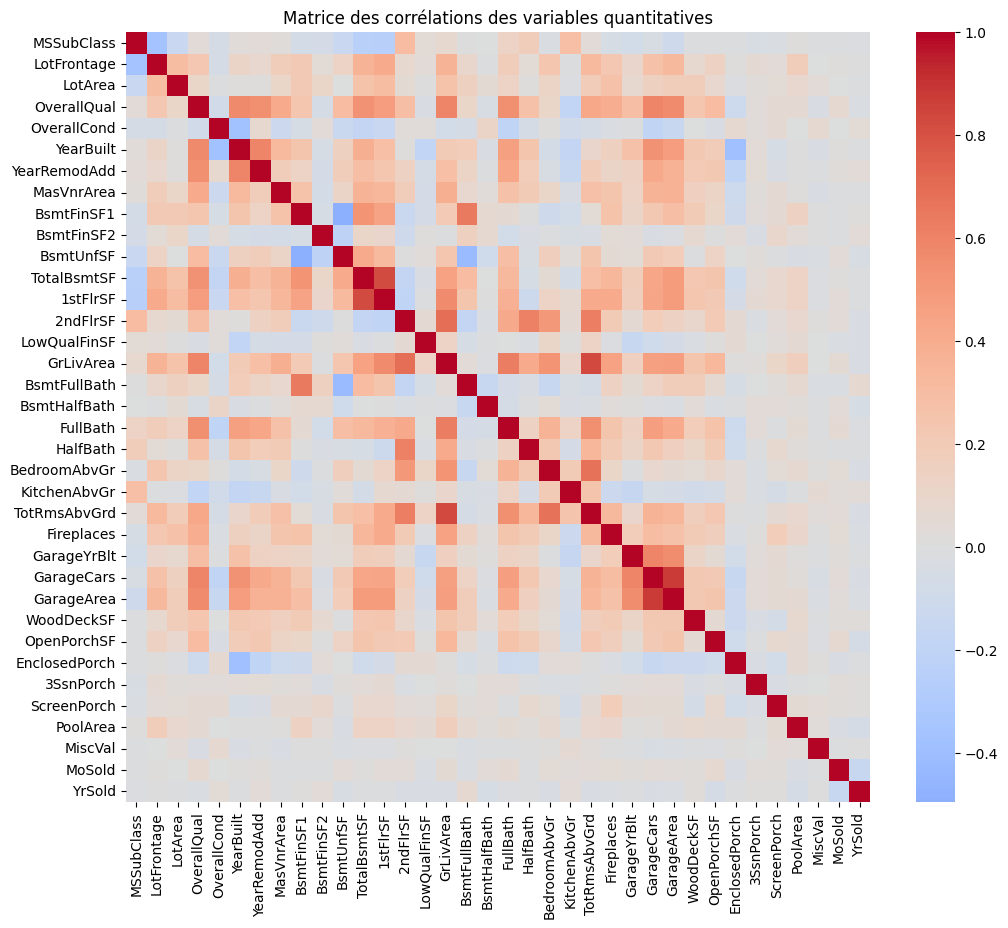

In [ ]:
donnees_quantitatives = train[variables_quantitatives]
matrice_correlation = donnees_quantitatives.corr()

# Affichage de la heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(matrice_correlation, cmap="coolwarm", center=0)
plt.title("Matrice des corrélations des variables quantitatives")
plt.show()

Identification des variables colinéaires

In [ ]:
# Mise à plat des corrélations absolues
correlations_fortes = (
    matrice_correlation.abs()
    .unstack()
    .sort_values(ascending=False)
)

# On enlève les corrélations parfaites (variable avec elle-même)
correlations_fortes = correlations_fortes[
    (correlations_fortes < 1) & (correlations_fortes > 0.7)
]

correlations_fortes


,,0
GarageCars,GarageArea,0.882475
GarageArea,GarageCars,0.882475
GrLivArea,TotRmsAbvGrd,0.825489
TotRmsAbvGrd,GrLivArea,0.825489
TotalBsmtSF,1stFlrSF,0.819530
1stFlrSF,TotalBsmtSF,0.819530


Régression linéaire classique

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error


reg_lin = LinearRegression()
reg_lin.fit(X_train_prepare, y_train)

# Prédictions sur les données d'entraînement
y_pred_lin = reg_lin.predict(X_train_prepare)

# Calcul du RMSE
rmse_lin = np.sqrt(mean_squared_error(y_train, y_pred_lin))

rmse_lin

np.float64(0.09450579040417292)

In [ ]:
# Prédictions sur le jeu de test (échelle log)
y_test_pred_log_lin = reg_lin.predict(X_test_prepare)

# Retour à l’échelle originale du prix
y_test_pred_lin = np.exp(y_test_pred_log_lin)


In [ ]:
soumission_lin = pd.DataFrame({
    "Id": test["Id"],
    "SalePrice": y_test_pred_lin
})

soumission_lin.to_csv("soumission_rl_classique.csv", index=False)



RL avec la pénalisation Ridge

In [ ]:
from sklearn.linear_model import RidgeCV, LassoCV
from sklearn.metrics import mean_squared_error
import numpy as np

In [ ]:
#plage penalisation
alphas = np.logspace(-6, 6, 13)#meme plage que sur la documentation scikit-learn

# Ridge
ridge = RidgeCV(alphas=alphas, cv=5)
ridge.fit(X_train_prepare, y_train)

y_pred_ridge = ridge.predict(X_train_prepare)
rmse_ridge = np.sqrt(mean_squared_error(y_train, y_pred_ridge))

ridge.alpha_, rmse_ridge


(np.float64(10.0), np.float64(0.11136523800982061))

RL avec la pénalisation Lasso

In [ ]:
#Lasso
lasso = LassoCV(alphas=alphas, cv=5, max_iter=10000)
lasso.fit(X_train_prepare, y_train)

y_pred_lasso = lasso.predict(X_train_prepare)
rmse_lasso = np.sqrt(mean_squared_error(y_train, y_pred_lasso))

lasso.alpha_, rmse_lasso


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:656: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0326313044812121, tolerance: 0.01891283972369289
  model = cd_fast.sparse_enet_coordinate_descent(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:656: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.3180989113263619, tolerance: 0.018002422128285202
  model = cd_fast.sparse_enet_coordinate_descent(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:656: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.4630881566834315, tolerance: 0.018373848090999036
  model = cd_fast.sparse_enet_coordinate_descent(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:65

(np.float64(0.001), np.float64(0.12033209431761277))

In [ ]:
resultats_rmse = pd.DataFrame({
    "Modele": ["Ridge", "Lasso"],
    "RMSE": [rmse_ridge, rmse_lasso]
})

resultats_rmse


,Modele,RMSE
0,Ridge,0.111365
1,Lasso,0.120332


In [ ]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.model_selection import cross_val_score
import numpy as np

# Modèles
modele_lin = LinearRegression()
modele_ridge = Ridge(alpha=ridge.alpha_)
modele_lasso = Lasso(alpha=lasso.alpha_, max_iter=10000)
modele_enet = ElasticNet(alpha=ridge.alpha_, l1_ratio=0.5, max_iter=10000)

# RMSE en validation croisée avec 5 folds
rmse_cv_lin = np.sqrt(-cross_val_score(
    modele_lin, X_train_prepare, y_train,
    cv=5, scoring="neg_mean_squared_error"
)).mean()

rmse_cv_ridge = np.sqrt(-cross_val_score(
    modele_ridge, X_train_prepare, y_train,
    cv=5, scoring="neg_mean_squared_error"
)).mean()

rmse_cv_lasso = np.sqrt(-cross_val_score(
    modele_lasso, X_train_prepare, y_train,
    cv=5, scoring="neg_mean_squared_error"
)).mean()

rmse_cv_enet = np.sqrt(-cross_val_score(
    modele_enet, X_train_prepare, y_train,
    cv=5, scoring="neg_mean_squared_error"
)).mean()

rmse_cv_lin, rmse_cv_ridge, rmse_cv_lasso, rmse_cv_enet


(np.float64(0.15668463511435804),
 np.float64(0.1396464888040061),
 np.float64(0.1376635667490603),
 np.float64(0.3992282792085989))

In [ ]:
ridge = RidgeCV(
    alphas=np.logspace(-3, 3, 50),
    cv=5
)

ridge.fit(X_train_prepare, y_train)

y_test_pred_ridge = ridge.predict(X_test_prepare)
y_test_pred_ridge = np.expm1(y_test_pred_ridge)

soumission_ridge = pd.DataFrame({
    "Id": test["Id"],
    "SalePrice": y_test_pred_ridge
})

soumission_ridge.to_csv("soumission_ridge.csv", index=False)


In [ ]:
lasso = LassoCV(
    alphas=np.logspace(-4, 1, 50),
    cv=5,
    max_iter=10000
)

lasso.fit(X_train_prepare, y_train)

y_test_pred_lasso = lasso.predict(X_test_prepare)
y_test_pred_lasso = np.expm1(y_test_pred_lasso)

soumission_lasso = pd.DataFrame({
    "Id": test["Id"],
    "SalePrice": y_test_pred_lasso
})

soumission_lasso.to_csv("soumission_lasso.csv", index=False)


In [ ]:
elastic = ElasticNetCV(
    alphas=np.logspace(-4, 1, 50),
    l1_ratio=[0.2, 0.5, 0.8],
    cv=5,
    max_iter=10000
)

elastic.fit(X_train_prepare, y_train)

y_test_pred_elastic = elastic.predict(X_test_prepare)
y_test_pred_elastic = np.expm1(y_test_pred_elastic)

soumission_elastic = pd.DataFrame({
    "Id": test["Id"],
    "SalePrice": y_test_pred_elastic
})

soumission_elastic.to_csv("soumission_elastic.csv", index=False)


Random forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(
    n_estimators=300,
    max_depth=None,
    min_samples_leaf=1,
    random_state=4200,
    n_jobs=-1
)

# Validation croisée
rmse_cv_rf = np.sqrt(-cross_val_score(
    rf,
    X_train_prepare,
    y_train,
    cv=5,
    scoring="neg_mean_squared_error"
)).mean()

rmse_cv_rf


np.float64(0.1426369165469528)

In [ ]:
rf.fit(X_train_prepare, y_train)

y_test_pred_rf = rf.predict(X_test_prepare)
y_test_pred_rf = np.expm1(y_test_pred_rf)

soumission_rf = pd.DataFrame({
    "Id": test["Id"],
    "SalePrice": y_test_pred_rf
})

soumission_rf.to_csv("soumission_random_forest.csv", index=False)


Gradient boosting

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score
import numpy as np

gbr = GradientBoostingRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=3,
    random_state=42
)

# Validation croisée
rmse_cv_gbr = np.sqrt(-cross_val_score(
    gbr,
    X_train_prepare,
    y_train,
    cv=5,
    scoring="neg_mean_squared_error"
)).mean()

rmse_cv_gbr


np.float64(0.12372979446073051)

In [ ]:
gbr.fit(X_train_prepare, y_train)

y_test_pred_gbr = gbr.predict(X_test_prepare)
y_test_pred_gbr = np.expm1(y_test_pred_gbr)

soumission_gbr = pd.DataFrame({
    "Id": test["Id"],
    "SalePrice": y_test_pred_gbr
})

soumission_gbr.to_csv("soumission_gradient_boosting.csv", index=False)


XGBoost

In [ ]:
from xgboost import XGBRegressor

xgb = XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="reg:squarederror",
    random_state=42,
    n_jobs=-1
)

rmse_cv_xgb = np.sqrt(-cross_val_score(
    xgb,
    X_train_prepare,
    y_train,
    cv=5,
    scoring="neg_mean_squared_error"
)).mean()

rmse_cv_xgb


np.float64(0.12325529873378267)

In [ ]:
xgb.fit(X_train_prepare, y_train)

y_test_pred_xgb = xgb.predict(X_test_prepare)
y_test_pred_xgb = np.expm1(y_test_pred_xgb)

soumission_xgb = pd.DataFrame({
    "Id": test["Id"],
    "SalePrice": y_test_pred_xgb
})

soumission_xgb.to_csv("soumission_xgboost.csv", index=False)
